<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-building" data-toc-modified-id="Model-building-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model building</a></span></li><li><span><a href="#Probability" data-toc-modified-id="Probability-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Probability</a></span><ul class="toc-item"><li><span><a href="#Predict_proba" data-toc-modified-id="Predict_proba-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Predict_proba</a></span></li><li><span><a href="#Threshold" data-toc-modified-id="Threshold-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Threshold</a></span></li><li><span><a href="#ROC-AUC" data-toc-modified-id="ROC-AUC-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>ROC AUC</a></span></li><li><span><a href="#Log-Loss" data-toc-modified-id="Log-Loss-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Log Loss</a></span></li></ul></li><li><span><a href="#Correlation-between-features-and-target" data-toc-modified-id="Correlation-between-features-and-target-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Correlation between features and target</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('sales.csv')
df.dropna(subset=['price'], inplace=True)

In [3]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [4]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train_raw = df[df.year < 2015]
train_raw.index = range(len(train_raw))
test_raw = df[df.year >= 2015]
test_raw.index = range(len(test_raw))

## Model building


<font color='red'>Assignment:</font> Get **luxury** (**price** higher than 500k dollars) as targets, and build a end-to-end model to predict wheather a product is **luxury** using **cost** values.

In [5]:
def price2target(x):
    if type(x) == str:
        x = float(x.strip('$').replace(',',''))
    
    if x > 500000.0:
        return 1
    return 0

y_train = train_raw.price.map(price2target)
y_test =  test_raw.price.map(price2target)

In [6]:
class Cost_Transformer(object):
    
    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(lambda x: float(x.strip('$').strip('k')) * 1000 if type(x) == str else x)
        #self.median = df.median()
        self.mean = df.mean()
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(lambda x: float(x.strip('$').strip('k')) * 1000 if type(x) == str else x)
        #return df.fillna(self.median)
        return df.fillna(self.mean)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [92]:
ct = Cost_Transformer()

In [93]:
X_train = ct.fit_transform(train_raw)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

steps = [('ct ', Cost_Transformer())
         ,('Rescale', MinMaxScaler())
         ,('Lgr', LogisticRegression(class_weight='balanced'))]
pipe= Pipeline(steps)

lgrmodel=pipe.fit(train_raw, y_train)

y_train_pred = lgrmodel.predict(train_raw)
y_test_pred = lgrmodel.predict(test_raw)

## Probability

### Predict_proba

<font color='red'>Assignment:</font> Use the **predict_proba** function of the model to make predictions for the training and testing sets and assign the outputs to variables **y_train_proba** and **y_test_proba**.

In [8]:
y_train_proba = lgrmodel.predict_proba(train_raw)
y_test_proba = lgrmodel.predict_proba(test_raw)

<font color='red'>Question:</font> What are the shapes of **y_train_proba** and **y_test_proba**? Why are they different from the outputs obtained with the **predict** function? Which parts of **y_train_proba** and **y_test_proba** should we care about in this case? 

y_train_proba.shape= (2757, 2)
y_test_proba.shape= (429, 2)
y_train_pred.shape= (2757,)
y_test_pred.shape= (429,)

y_train_pred and y_test_pred, they are labels, type 0 or type 1.

Probability has two columns: Probability to be 0 and probability to be 1.

We care about column['1'], minor sample group.

In [9]:
print('y_train_proba.shape=',y_train_proba.shape)
print('y_test_proba.shape=',y_test_proba.shape)

y_train_proba.shape= (2757, 2)
y_test_proba.shape= (429, 2)


In [10]:
y_train_pred

array([1, 0, 1, ..., 0, 0, 0])

In [11]:
y_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,

<font color='red'>Question:</font> What is the range of the values in **y_train_proba** and **y_test_proba**? What do the values mean?


In [36]:
df_prob_train = pd.DataFrame(y_train_proba)
df_prob_train.columns = ['prob=0','prob=1']
df_prob_train

,prob=0,prob=1
0,0.275364,0.724636
1,0.661630,0.338370
2,0.413646,0.586354
3,0.794123,0.205877
4,0.848531,0.151469
...,...,...
2752,0.452199,0.547801
2753,0.803589,0.196411
2754,0.661630,0.338370
2755,0.866507,0.133493


In [13]:
df_prob_test = pd.DataFrame(y_test_proba)
df_prob_test.columns = ['prob=0','prob=1']
df_prob_test

,prob=0,prob=1
0,0.661630,0.338370
1,0.675090,0.324910
2,0.675090,0.324910
3,0.661630,0.338370
4,0.893381,0.106619
...,...,...
424,0.874260,0.125740
425,0.661630,0.338370
426,0.038554,0.961446
427,0.661630,0.338370


In [14]:
train_prob_range = [min(df_prob_train['prob=1']),max(df_prob_train['prob=1'])]
print('train_prob_range=',train_prob_range)

train_prob_range= [0.09337985566062995, 0.9990682052928109]


In [15]:
test_prob_range = [min(df_prob_test['prob=1']),max(df_prob_test['prob=1'])]
print('test_prob_range=',test_prob_range)

test_prob_range= [0.09337985566062995, 0.9956607865394056]


### Threshold

<font color='red'>Assignment:</font> Plot **y_test_proba** versus **cost** and compare it with the plot of **y_test** versus **cost**.

In [16]:
cost_test = Cost_Transformer().fit_transform(test_raw)

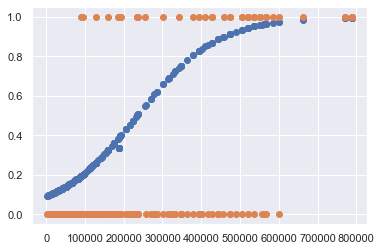

In [17]:
plt.scatter(cost_test, y_test_proba[:,1])
plt.scatter(cost_test,y_test)

<font color='red'>Assignment:</font> Calculate **y_test_pred** using **predict** function. Plot **y_test_proba** versus **cost** and compare it with the plot of **y_test_pred** versus **cost**.

In [18]:
y_test_pred = lgrmodel.predict(test_raw)

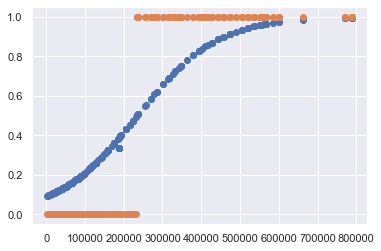

In [19]:
plt.scatter(cost_test, y_test_proba[:,1])
plt.scatter(cost_test,y_test_pred)

<font color='red'>Question:</font> How can we transform **y_test_proba** to **y_test_pred**? What is the default threshold?

for i in y_test_proba:
    if i > 0.5:
        y_test_pred = 1
    else:
        y_test_pred = 0

<font color='red'>Assignment:</font> Change the threshold value applied in the transformation from **y_test_proba** to **y_test_pred**, and visualize how the threshold value changes **precision**, **recall**, and **f1 score**. 

In [20]:
df_prob_test = pd.DataFrame(y_test_proba)
df_prob_test.columns = ['prob=0','prob=1']
df_prob_test

,prob=0,prob=1
0,0.661630,0.338370
1,0.675090,0.324910
2,0.675090,0.324910
3,0.661630,0.338370
4,0.893381,0.106619
...,...,...
424,0.874260,0.125740
425,0.661630,0.338370
426,0.038554,0.961446
427,0.661630,0.338370


In [23]:
class prob_threshold_transform(object):
    
    def prob_threshold(self, df_prob, threshold):
        '''
        provide df_probability with a certin threshold
        '''
        
        prob_th_form = pd.DataFrame()
        for i in range(df_prob.shape[0]):
            column_name = 'y_test_pred (threshold='+str(round(threshold,1))+')'
            if df_prob.loc[i,'prob=1'] > threshold:
                prob_th_form.loc[i,column_name] = 1
            else:
                prob_th_form.loc[i,column_name] = 0
        return prob_th_form       

    def th_form(self, df_prob): 
        '''
        create a dataframe, 
        shows the type of label with threshold from 0.1~1
        '''
        th_form = pd.DataFrame()
        thresholds = [i for i in np.linspace(0.1, 1, 10)]
        
        for threshold in thresholds:
            df_= self.prob_threshold(df_prob, threshold)
            th_form = pd.concat([th_form,df_],axis=1)
        return th_form  

In [24]:
ptd = prob_threshold_transform()
#ptd.th_form(df_prob_test)

In [25]:
y_test_prob = ptd.th_form(df_prob_test)
y_test_prob

,y_test_pred (threshold=0.1),y_test_pred (threshold=0.2),y_test_pred (threshold=0.3),y_test_pred (threshold=0.4),y_test_pred (threshold=0.5),y_test_pred (threshold=0.6),y_test_pred (threshold=0.7),y_test_pred (threshold=0.8),y_test_pred (threshold=0.9),y_test_pred (threshold=1.0)
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
424,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
425,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
426,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
427,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


class get_scores(object):
    
    def __init__(self, df_prob, y_true):
        self.precision = []
        self.recall = []
        self.f1 = []
        self.df_prob = df_prob
        self.y_true = y_true
       
        
    def scores_list(self, y_pred):
    
        # precision
        #train_precision = metrics.precision_score(y_train, y_train_pred)
        precision = metrics.precision_score(self.y_true, y_pred)
        # Recall
        #train_recall = metrics.recall_score(y_train, y_train_pred)
        recall = metrics.recall_score(self.y_true, y_pred)
        # F1-score
        #train_f1_score = metrics.f1_score(y_train, y_train_pred)
        f1_score = metrics.f1_score(self.y_true, y_pred)
        
        self.precision.append(precision)
        self.recall.append(recall)
        self.f1.append(f1_score)
        
    def get_scores_from_prob_threshold_form(self):
        
        for i in range(self.df_prob.shape[1]):
            y_pred = self.df_prob.iloc[:, i]    #df_prob = y_test_prob
            self.scores_list(y_pred)


In [28]:

def plot(precision, recall, f1):
    
    #print('ts.precision=',ts.precision)
    #print('test_recall=',ts.recall)
    #print('F1-score=',ts.f1)

    plt.figure(figsize=(8,6))
    plt.plot(np.linspace(0.1, 1, 10), precision,label = 'precision')
    plt.plot(np.linspace(0.1, 1, 10), recall, label = 'recall')
    plt.plot(np.linspace(0.1, 1, 10), f1, label = 'f1')
    plt.legend()
    plt.show

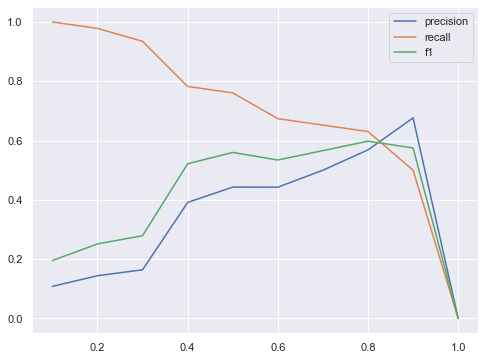

In [29]:
gs = get_scores(y_test_prob, y_test)
gs.get_scores_from_prob_threshold_form()
plot(gs.precision, gs.recall, gs.f1)

<font color='red'>Question:</font> What threshold value would you like to choose? How do we decide which threshold to choose? Could you provide some examples?

In [30]:
0.3

0.3

<font color='red'>Question:</font> Is the threshold a hyper parameter? What kind of dataset should we use to find the threshold?

No. 

Train set.

### ROC AUC

<font color='red'>Assignment:</font> Calculate the train and test **roc_auc_score**s. 

In [31]:
y_train = train_raw.price.map(price2target)
y_train

0       0
1       0
2       0
3       0
4       0
       ..
2752    0
2753    0
2754    0
2755    0
2756    0
Name: price, Length: 2757, dtype: int64

In [32]:
y_train_pred = lgrmodel.predict(train_raw)
y_train_pred.shape

(2757,)

In [39]:
y_train_proba = lgrmodel.predict_proba(train_raw)
y_train_proba

array([[0.27536354, 0.72463646],
       [0.66162999, 0.33837001],
       [0.41364604, 0.58635396],
       ...,
       [0.66162999, 0.33837001],
       [0.86650741, 0.13349259],
       [0.73991718, 0.26008282]])

In [84]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def get_all_scores(y_train, y_test, y_train_pred, y_test_pred, y_train_proba, y_test_proba):
    #accuracy
    train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
    test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
    
    # precision
    train_precision = metrics.precision_score(y_train, y_train_pred)
    test_precision = metrics.precision_score(y_test, y_test_pred)
    
    # Recall
    train_recall = metrics.recall_score(y_train, y_train_pred)
    test_recall = metrics.recall_score(y_test, y_test_pred)
    
    # F1-score
    train_f1_score = metrics.f1_score(y_train, y_train_pred)
    test_f1_score = metrics.f1_score(y_test, y_test_pred)
    
    # AUC
    train_auc_score = metrics.roc_auc_score(y_train, y_train_proba)
    test_auc_score = metrics.roc_auc_score(y_test, y_test_proba)
    
    # ROC
    train_fprs, train_tprs, train_thresholds = metrics.roc_curve(y_train, y_train_proba)
    test_fprs, test_tprs, test_thresholds = metrics.roc_curve(y_test, y_test_proba)
    
    
    #probrange = np.linspace(y_train_proba[:,1].min(),y_train_proba[:,1].max(),50,endpoint=False)
    #plt.plot(probrange+0.05,probrange+0.05,color="black",linestyle="--")
    
    plt.plot(train_fprs, train_tprs,label = 'roc_train_set')
    plt.plot(test_fprs, test_tprs,label = 'roc_test_set')
    plt.title("ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc = 4)
    plt.show()
    
    
    #Print
    print("train_accuracy：", train_accuracy)
    print("test_accuracy：", test_accuracy)
    print("train_precision：", train_precision)
    print("test_precision：", test_precision)
    print("train_recall：", train_recall)
    print("test_recall：", test_recall)
    print("train_f1_score：", train_f1_score)
    print("test_f1_score：", test_f1_score)
    print("train_auc_score：", train_auc_score)
    print("test_auc_score：", test_auc_score)
    


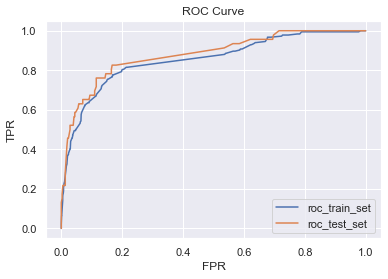

train_accuracy： 0.8581791802684077
test_accuracy： 0.8717948717948718
train_precision： 0.278372591006424
test_precision： 0.4430379746835443
train_recall： 0.7065217391304348
test_recall： 0.7608695652173914
train_f1_score： 0.39938556067588327
test_f1_score： 0.5599999999999999
train_auc_score： 0.8540709119789114
test_auc_score： 0.8788454989215575


In [85]:
get_all_scores(y_train, y_test, y_train_pred, y_test_pred, y_train_proba[:,1], y_test_proba[:,1])

<font color='red'>Question:</font> What do **ROC** and **AUC** stand for? 

When we need to check or visualize the performance of the multi-class classification problem, we use the AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve. It is one of the most important evaluation metrics for checking any classification model's performance.

<font color='red'>Assignment:</font> Plot the ROC curve of test scores, use the **roc_curve** module in sklearn to obtain relevant data. 

See above

<font color='red'>Question:</font> What are the x and y axes? 

X: False positive rate, y: true positive rate

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

<font color='red'>Question:</font> What is the range of **roc_auc_score**? What does it mean when **roc_auc_score** is greater than, equal to, or less than 0.5?

In [58]:
[y_train_proba[:,1].min(),y_train_proba[:,1].max()]

[0.09337985566062995, 0.9990682052928109]

### Log Loss

**Knowledge:** The loss function for logistic regression is called **log loss** or **cross entropy**.

<font color='red'>Assignment:</font> Calculate the train and test log loss.

In [75]:
from sklearn.metrics import log_loss

In [78]:
log_loss(y_train, y_train_proba)

0.4585697586776646

In [79]:
log_loss(y_test, y_test_proba)

0.47312495144145705

<font color='red'>Question:</font> Which of these following terms are sensitive to base rates: **log loss**, **ROC AUC**, and **threshold**?



https://towardsdatascience.com/intuition-behind-log-loss-score-4e0c9979680a


binary log_loss = y_pred*log(1-y_true) + (1-y_pred)log(y_true)


<font color='red'>Question:</font> If you are assigned to build a classification model to help increasing the <span class="burk"><span class="mark">response rate</span></span> in direct mail marketing, what will be the target for you model? Which metrics will you use to evaluate the performance of your model?

Target of the model: customer response ->1, not response -> 0, or the probability of customer responsing.

ROC.

## Correlation between features and target

<font color='red'>Assignment:</font> Plot the distributions of **cost** values for positive and negative **luxury** items, respectively, in one figure. Use the data in the training set.

In [136]:
#X_train

In [137]:
#y_train

In [116]:
y_1 = y_train[y_train == 1]
y_0 = y_train[y_train ==0]
X_1 = X_train.iloc[y_1.index,:]
X_0 = X_train.iloc[y_0.index,:]

[]

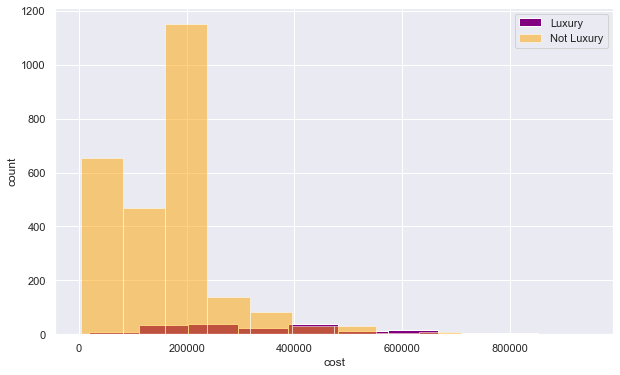

In [174]:
plt.figure(figsize=(10,6))
plt.hist(X_1,alpha = 1, color ='purple', label = 'Luxury')
plt.hist(X_0,alpha = 0.5,color ='orange',label = 'Not Luxury')
plt.xlabel('cost')
plt.ylabel('count')
plt.legend()
plt.plot()

<font color='red'>Question:</font> From the above figure, can you tell how good **cost** is a predictor for luxury?

Not good. It is hard to see a clear trend of cost vs. luxury or not.

**Example:** Mannualy calculate the ROC AUC score of cost predictor. We can use this method to estimate the importance of a feature, before we use it in a model.

In [192]:
# preparation
train = Cost_Transformer().fit_transform(train_raw)
train['price'] = y_train
train.head()

,cost,price
0,333000.000000,0
1,166184.183143,0
2,270000.000000,0
3,97000.000000,0
4,59000.000000,0


In [194]:
# number of positive data points
num_pos = sum(train.price)
# number of negative data points
num_neg = len(train) - num_pos
# thresholds
ths = sorted(list(train.cost.unique()))

In [89]:
tprs = []
fprs = []
auc = 0.0
tpr0 = 1.0
fpr0 = 1.0
for th in ths:
    # true positive rates
    true_pos = sum(train[train['cost'] >= th]['price'])
    tpr = true_pos / num_pos
    tprs.append(tpr)
    
    # false positive rates
    false_pos = sum(train['cost'] >= th) - true_pos
    fpr = false_pos / num_neg
    fprs.append(fpr)
    
    # area under curve
    auc += (fpr0 - fpr) * (tpr0 + tpr)/2.0
    fpr0 = fpr
    tpr0 = tpr
    

Text(0, 0.5, 'true positive rate')

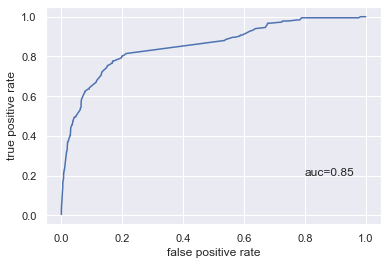

In [90]:
plt.plot(fprs, tprs)
plt.text(0.8, 0.2, 'auc={0:.2f}'.format(auc))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')